In [1]:
import sys
sys.path.insert(1, '/home/sam/Documents/network/supernode/BREC_test/')

In [2]:
import numpy as np
import torch
import torch_geometric
import torch_geometric.loader
from loguru import logger
import time
from BRECDataset_v3 import BRECDataset
from tqdm import tqdm
import os
from torch.nn import CosineEmbeddingLoss
import argparse

from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import degree
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GIN, MLP, global_add_pool
import torch_geometric.transforms as T

import hashlib

from concepts.concepts import *
from concepts.transformations import AddSupernodesHeteroMulti
from models.gnn_hetero_multi import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

def visualize(g, transf, set_labels=None):
    if set_labels:
        set_labels = nx.get_node_attributes(g, set_labels) 
        
    if transf:
        ntype = set(nx.get_node_attributes(g, "ntype").values())
        ntype.remove('ORIG')
        
        nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), 
                     node_color=['#1f78b4' if n=='ORIG' else '#1fffff' for n in nx.get_node_attributes(g, "ntype").values()],
                     labels = set_labels
                    )
    else:
        nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), labels = set_labels)

def showConcepts(g, k, v):
    N = list(g.neighbors(k))
    N.append(k)
    
    print(list(g.neighbors(k)), v, k)
    nx.draw_networkx(G=g, pos=nx.spring_layout(g, np.random.seed(1234)), 
                 node_color=['#1fffff' if n in N else '#1f78b4' for n in nx.nodes(g)]                    )
    plt.show()

def my_to_networkx2(data):
    normalnodes    = list(range(data['normal'].x.shape[0]))
    normal_ei      = data['normal', 'orig', 'normal'].edge_index
    
    nodes_type = list(data.x_dict.keys())
    nodes_type.remove('normal')
    print(nodes_type)
    
    curr_num = data['normal'].x.shape[0]
    tensor_list = []
    supernodes_list = []
    for node_type in nodes_type:
        norm_to_sup_ei = data['normal', 'toSup', node_type].edge_index.clone()
        next_num = curr_num+data[node_type].x.shape[0]
        supernodes = torch.arange(curr_num, next_num)
        supernodes_list.append(supernodes)
          
        for i in range(len(supernodes)):
            t2 = norm_to_sup_ei[1]
            t2[t2 == i] = supernodes[i]
    
        tensor_list.append(norm_to_sup_ei)
        curr_num = next_num
    
    
    norm_to_sup_ei = torch.cat(tensor_list, dim=1)
    supernodes     = torch.cat(supernodes_list, dim=0)
    
    
    G = nx.Graph()
    G.add_nodes_from(normalnodes)
    G.add_edges_from(list(zip(normal_ei[0].tolist(), normal_ei[1].tolist())))
    G.add_nodes_from(supernodes.tolist())
    G.add_edges_from(list(zip(norm_to_sup_ei[0].tolist(), norm_to_sup_ei[1].tolist())))
    
    dictA = {**{key: 'ORIG' for key in normalnodes}, **{key: 'SUP' for key in supernodes.tolist()}}
    nx.set_node_attributes(G, dictA, "ntype")
    return G

In [8]:
def get_dataset(device):
    time_start = time.process_time()

    def makefeatures(data):
        data.x = torch.ones((data.num_nodes, 1))
        return data

    concepts_list_ex = [
           {"name": "GCB", "fun": cycle_basis, "args": [200]}, # max_num
           {"name": "GMC", "fun": max_cliques, "args": []},
           {"name": "GLP2", "fun": line_paths, "args": []}
        ]

    path_name = ''.join(map(lambda x: x['name'] + str(x['args']), concepts_list_ex))
    hash_name = hashlib.sha256(path_name.encode('utf-8')).hexdigest()
    name = f"BREC_supernode_multi{hash_name}"

    supnodes_names = [concept['name'] for concept in concepts_list_ex]
    sup_transform = AddSupernodesHeteroMulti(concepts_list_ex)
    pre_transform = T.Compose([makefeatures, sup_transform])
    # Do something
    dataset = BRECDataset(dataset_path="/home/sam/Documents/network/supernode/dataset/BREC_raw",
                          name=name,
                          pre_transform=pre_transform)
    data1 = dataset[0]


    time_end = time.process_time()
    time_cost = round(time_end - time_start, 2)
    logger.info(f"dataset construction time cost: {time_cost}")

    return dataset, supnodes_names, data1


def get_dataset_normal(device):
    time_start = time.process_time()

    def makefeatures(data):
        data.x = torch.ones((data.num_nodes, 1))
        return data


    name = f"BREC_supernode_multi_normal"

    # Do something
    dataset = BRECDataset(dataset_path="/home/sam/Documents/network/supernode/dataset/BREC_raw",
                          name=name,
                          pre_transform=makefeatures)

    return dataset

In [9]:
dataset, supnodes_name, data1 = get_dataset(device=device)


Processing...


KeyboardInterrupt: 

In [7]:
dataset[0]

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[32, 1] },
  GMC={ x=[13, 1] },
  (normal, orig, normal)={ edge_index=[2, 52] },
  (normal, toSup, GCB)={ edge_index=[2, 110] },
  (GCB, toNor, normal)={ edge_index=[2, 110] },
  (normal, toSup, GMC)={ edge_index=[2, 41] },
  (GMC, toNor, normal)={ edge_index=[2, 41] }
)

In [5]:
dataset_normal = get_dataset_normal(device=device)

Data(edge_index=[2, 52], x=[10, 1], num_nodes=10)
13
32


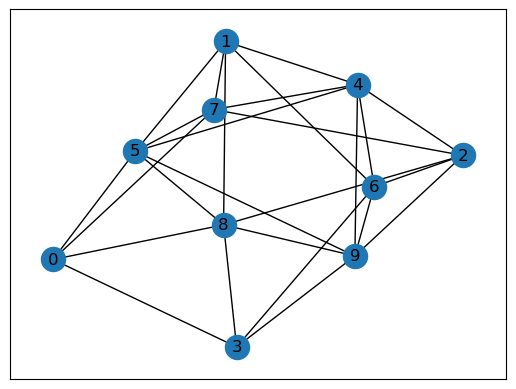

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx

data1 = dataset_normal[0]
print(data1)
G = to_networkx(data1, to_undirected=True)
visualize(G, False)
print(len(max_cliques(G)))
print(len(cycle_basis(G)))

In [7]:
print(dataset[0])
print(dataset[0]['normal', 'toSup', 'GCB'])
print(dataset[0]['normal', 'toSup', 'GMC'])

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[32, 1] },
  GMC={ x=[13, 1] },
  (normal, orig, normal)={ edge_index=[2, 52] },
  (normal, toSup, GCB)={ edge_index=[2, 110] },
  (GCB, toNor, normal)={ edge_index=[2, 110] },
  (normal, toSup, GMC)={ edge_index=[2, 41] },
  (GMC, toNor, normal)={ edge_index=[2, 41] }
)
{'edge_index': tensor([[ 7,  4,  9,  8,  0,  1,  6,  9,  8,  1,  4,  9,  8,  7,  2,  8,  0,  7,
          1,  8,  0,  6,  3,  8,  1,  4,  2,  8,  1,  6,  2,  8,  1,  7,  2,  8,
          1,  7,  5,  9,  2,  6,  1,  5,  9,  3,  0,  5,  9,  2,  8,  5,  7,  3,
          8,  0,  5,  8,  0,  2,  9,  8,  3,  9,  8,  5,  9,  8,  2,  6,  9,  3,
          6,  9,  4,  6,  9,  2,  4,  9,  5,  4,  9,  5,  1,  8,  5,  7,  0,  4,
          7,  1,  5,  7,  1,  4,  6,  1,  4,  5,  1,  4,  7,  2,  4,  6,  2,  4,
          7,  5],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
          4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,
 

In [8]:
part_dict = {
    "Basic": (0, 60),
    "Regular": (60, 160),
    "Extension": (160, 260),
    "CFI": (260, 360),
    "4-Vertex_Condition": (360, 380),
    "Distance_Regular": (380, 400),
}

# NORMAL

In [9]:
SAMPLE_NUM = 400
NUM_RELABEL = 32
id = 1
BATCH_SIZE=1
dataset_reliability = dataset_normal[
    (id + SAMPLE_NUM)
    * NUM_RELABEL
    * 2 : (id + SAMPLE_NUM + 1)
    * NUM_RELABEL
    * 2
]
loader = torch_geometric.loader.DataLoader(dataset_reliability, batch_size=BATCH_SIZE)


DataBatch(edge_index=[2, 76], x=[10, 1], num_nodes=10, batch=[10], ptr=[2])
74
4
x tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
       

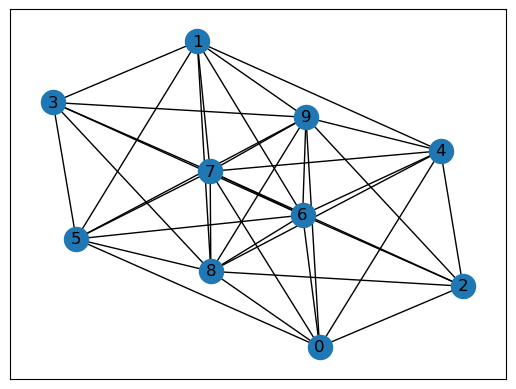

In [10]:
### data1 = dataset_reliability[0]
data1 = next(iter(loader))
print(data1)
G = to_networkx(data1, to_undirected=True)
visualize(G, False)
print(len(cycle_basis(G)))
print(len(max_cliques(G)))

concepts_list = [
       {"name": "GCB", "fun": cycle_basis, "args": [200]}, # max_num
       {"name": "GMC", "fun": max_cliques, "args": []},
#           {"name": "GLP2", "fun": line_paths, "args": []}
    ]

for concept in concepts_list:
    concept_name = concept["name"]
    comp = concept["fun"](G, *concept["args"])
    if len(comp) != 0:
        current_supernode = 0
        from_normal = []
        to_sup      = []
        supnodes    = []
        for concept in comp:
            supnodes.append(current_supernode)
            for node in concept:
                from_normal.append(node)
                to_sup.append(current_supernode)
            current_supernode += 1
    
        toSup_edges = torch.Tensor((from_normal, to_sup)).long()
        toNor_edges = torch.Tensor((to_sup, from_normal)).long()
        #data_with_supernodes[concept_name].x = torch.zeros(len(comp), data.num_features)
        print("x", torch.ones(len(comp), data1.num_features))
        print(('normal', 'toSup', concept_name), toSup_edges)
        print((concept_name, 'toNor', 'normal'), toNor_edges)

In [7]:
concepts_list = [
       {"name": "GCB", "fun": cycle_basis, "args": [200]}, # max_num
       {"name": "GMC", "fun": max_cliques, "args": []},
#           {"name": "GLP2", "fun": line_paths, "args": []}
    ]
data1T = AddSupernodesHeteroMulti(concepts_list)(data1)
data1T

AttributeError: 'HeteroData' has no attribute 'x'

# TRANSF

In [12]:
SAMPLE_NUM = 400
NUM_RELABEL = 32
id = 1
BATCH_SIZE=1
print((id + SAMPLE_NUM) * NUM_RELABEL * 2 )
print((id + SAMPLE_NUM + 1) * NUM_RELABEL * 2)

dataset_reliability2 = dataset[
    (id + SAMPLE_NUM)
    * NUM_RELABEL
    * 2 : (id + SAMPLE_NUM + 1)
    * NUM_RELABEL
    * 2
]
loader2 = torch_geometric.loader.DataLoader(dataset_reliability2, batch_size=BATCH_SIZE)

25664
25728


In [13]:
data2 = next(iter(loader2))
print(data2)
print(data2['normal', 'toSup', 'GMC'].edge_index[1])

HeteroDataBatch(
  normal={
    x=[10, 1],
    batch=[10],
    ptr=[2],
  },
  GCB={
    x=[74, 1],
    batch=[74],
    ptr=[2],
  },
  GMC={
    x=[4, 1],
    batch=[4],
    ptr=[2],
  },
  (normal, orig, normal)={ edge_index=[2, 76] },
  (normal, toSup, GCB)={ edge_index=[2, 222] },
  (GCB, toNor, normal)={ edge_index=[2, 222] },
  (normal, toSup, GMC)={ edge_index=[2, 674] },
  (GMC, toNor, normal)={ edge_index=[2, 674] }
)
tensor([  0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   2,   2,   2,   2,
          3,   3,   3,   3,   4,   4,   4,   4,   4,   5,   5,   5,   5,   6,
          6,   6,   6,   7,   7,   7,   7,   8,   8,   8,   8,   9,   9,   9,
          9,  10,  10,  10,  10,  10,  11,  11,  11,  11,  12,  12,  12,  12,
         13,  13,  13,  13,  14,  14,  14,  14,  15,  15,  15,  15,  16,  16,
         16,  16,  17,  17,  17,  17,  18,  18,  18,  18,  19,  19,  19,  19,
         20,  20,  20,  20,  21,  21,  21,  21,  22,  22,  22,  22,  23,  23,
         23,  23,  24, 

In [14]:
start = (id + SAMPLE_NUM) * NUM_RELABEL * 2
dataset[start]

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[74, 1] },
  GMC={ x=[4, 1] },
  (normal, orig, normal)={ edge_index=[2, 76] },
  (normal, toSup, GCB)={ edge_index=[2, 222] },
  (GCB, toNor, normal)={ edge_index=[2, 222] },
  (normal, toSup, GMC)={ edge_index=[2, 674] },
  (GMC, toNor, normal)={ edge_index=[2, 674] }
)

In [15]:
dataset_normal[start]
start

25664

# TEST COMPARISON

In [16]:
dataset, supnodes_name, data1 = get_dataset(device=device)
dataset_normal = get_dataset_normal(device=device)

2024-02-15 14:20:48.966 | INFO     | __main__:get_dataset:30 - dataset construction time cost: 1.73


In [17]:
d1 = dataset[start]

In [18]:
d2 = AddSupernodesHeteroMulti(concepts_list)(dataset_normal[start])

In [19]:
for i, d1 in enumerate(dataset):
    print(i)
    d2 = AddSupernodesHeteroMulti(concepts_list)(dataset_normal[i])
    types = d1.metadata()[0]
    edges = d1.metadata()[1]
    test = all([torch.equal(d1[type].x, d2[type].x) for type in types]) and all([torch.equal(d1[edge].edge_index, d2[edge].edge_index) for edge in edges])
    if not test:
        print(i)
        print(d1,d2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'EdgeStorage' object has no attribute 'edge_index'

In [20]:
q1 = dataset[4033]
print(q1)
print(q1["normal", "orig", "normal"].edge_index)
print(q1["normal", "toSup", "GMC"].edge_index)

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[36, 1] },
  GMC={ x=[1, 1] },
  (normal, orig, normal)={ edge_index=[2, 40] },
  (normal, toSup, GCB)={ edge_index=[2, 160] },
  (GCB, toNor, normal)={ edge_index=[2, 160] },
  (normal, toSup, GMC)={ edge_index=[2, 6] },
  (GMC, toNor, normal)={ edge_index=[2, 6] }
)
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9],
        [1, 2, 3, 4, 0, 5, 6, 7, 0, 5, 6, 7, 0, 5, 8, 9, 0, 5, 8, 9, 1, 2, 3, 4,
         1, 2, 8, 9, 1, 2, 8, 9, 3, 4, 6, 7, 3, 4, 6, 7]])
tensor([[1, 3, 5, 4, 8, 2],
        [0, 0, 0, 1, 1, 1]])


In [21]:
q2 = AddSupernodesHeteroMulti(concepts_list)(dataset_normal[4033])
print(q2)
print(q2["normal", "orig", "normal"].edge_index)

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[36, 1] },
  GMC={ x=[1, 1] },
  (normal, orig, normal)={ edge_index=[2, 40] },
  (normal, toSup, GCB)={ edge_index=[2, 160] },
  (GCB, toNor, normal)={ edge_index=[2, 160] }
)
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9],
        [1, 2, 3, 4, 0, 5, 6, 7, 0, 5, 6, 7, 0, 5, 8, 9, 0, 5, 8, 9, 1, 2, 3, 4,
         1, 2, 8, 9, 1, 2, 8, 9, 3, 4, 6, 7, 3, 4, 6, 7]])


In [22]:
max_cliques(to_networkx(dataset_normal[4033], to_undirected=True))

[]

In [13]:
def get_HGT_multi(args, data, hidden_channels=64, num_layers=4,
                  dropout=0.5, num_heads=4, out_channels=16):

    class HGT_multi(torch.nn.Module):
        def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
            super().__init__()

            self.lin_dict = torch.nn.ModuleDict()
            for node_type in data.node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                               num_heads, group='sum')
                self.convs.append(conv)

            self.readout = global_add_pool
            self.classifier = MLP([hidden_channels, hidden_channels, out_channels],
                                   norm="batch_norm", dropout=dropout)

        def forward(self, data):
            x_dict, edge_index_dict = (data.x_dict, data.edge_index_dict)

            x_dict = {
                node_type: self.lin_dict[node_type](x).relu_()
                for node_type, x in x_dict.items()
            }

            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)

            return x_dict

    model = HGT_multi(hidden_channels, out_channels, num_heads, num_layers)
    return model

In [14]:
model = get_HGT_multi("test", dataset[0])

data1 = dataset[start]
data2 = AddSupernodesHeteroMulti(concepts_list)(dataset_normal[start])

print(data2)

pred = model(data2)
print(pred)

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[74, 1] },
  GMC={ x=[4, 1] },
  (normal, orig, normal)={ edge_index=[2, 76] },
  (normal, toSup, GCB)={ edge_index=[2, 222] },
  (GCB, toNor, normal)={ edge_index=[2, 222] },
  (normal, toSup, GMC)={ edge_index=[2, 26] },
  (GMC, toNor, normal)={ edge_index=[2, 26] }
)
{'normal': tensor([[ 2.8022e-02, -3.2333e-02,  3.0216e-02, -8.1056e-02,  2.0233e-02,
         -4.6037e-03,  3.7923e-02, -4.5671e-02,  2.8558e-02, -2.4724e-04,
         -3.1748e-02, -6.6798e-03,  6.9168e-02,  4.6096e-02, -2.5010e-02,
         -6.2513e-02, -6.3692e-02, -3.3442e-03,  4.5143e-02, -7.5176e-02,
         -2.7940e-02,  6.1957e-02, -1.0124e-01,  6.9995e-02,  5.3701e-02,
          1.8788e-02, -6.3977e-02,  8.1192e-02,  6.5895e-02,  1.0644e-01,
          1.4056e-02,  6.5461e-03,  3.8425e-02,  7.2734e-02, -4.7669e-02,
         -3.3062e-02,  6.1078e-02, -4.8414e-02, -5.3990e-02,  5.7414e-02,
          2.3063e-02, -5.1318e-03,  7.5670e-03, -8.3254e-02, -6.6505e-02,
      

In [43]:
data1

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[74, 1] },
  GMC={ x=[4, 1] },
  (normal, orig, normal)={ edge_index=[2, 76] },
  (normal, toSup, GCB)={ edge_index=[2, 222] },
  (GCB, toNor, normal)={ edge_index=[2, 222] },
  (normal, toSup, GMC)={ edge_index=[2, 674] },
  (GMC, toNor, normal)={ edge_index=[2, 674] }
)

In [44]:
data2

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[74, 1] },
  GMC={ x=[4, 1] },
  (normal, orig, normal)={ edge_index=[2, 76] },
  (normal, toSup, GCB)={ edge_index=[2, 222] },
  (GCB, toNor, normal)={ edge_index=[2, 222] },
  (normal, toSup, GMC)={ edge_index=[2, 26] },
  (GMC, toNor, normal)={ edge_index=[2, 26] }
)

In [8]:
transformed_dataset = [AddSupernodesHeteroMulti(concepts_list)(data) for data in dataset_normal]

In [47]:
len(dataset_normal)

51200

In [48]:
len(transformed_dataset)

51200

In [50]:
pred = model(transformed_dataset[start])
pred

{'normal': tensor([[-0.0280, -0.0932, -0.0712, -0.0117,  0.0062, -0.0598,  0.0562,  0.0599,
          -0.0324, -0.0672,  0.0493,  0.0889,  0.0519, -0.0813, -0.0229,  0.0127,
          -0.0726, -0.0109,  0.0306, -0.0292,  0.0746, -0.0524,  0.0067,  0.0510,
           0.0962, -0.0123,  0.0006, -0.0528, -0.0068,  0.0782,  0.0064,  0.0245,
           0.0641,  0.0478, -0.0691,  0.0387, -0.0878,  0.0589, -0.0695, -0.0146,
          -0.0427, -0.0036,  0.0487, -0.0035,  0.0661,  0.0796,  0.0583,  0.0083,
           0.0790,  0.0370, -0.0660, -0.0571,  0.0543, -0.0788,  0.0567, -0.0351,
          -0.0267,  0.0042, -0.0958, -0.0573, -0.0775,  0.0145, -0.0759,  0.0370],
         [-0.0280, -0.0932, -0.0712, -0.0117,  0.0062, -0.0598,  0.0562,  0.0599,
          -0.0324, -0.0672,  0.0493,  0.0889,  0.0519, -0.0813, -0.0229,  0.0127,
          -0.0726, -0.0109,  0.0306, -0.0292,  0.0746, -0.0524,  0.0067,  0.0510,
           0.0962, -0.0123,  0.0006, -0.0528, -0.0068,  0.0782,  0.0064,  0.0245,
     

In [9]:
# Define the chunk size
chunk_size = 5000  # You can adjust this based on your memory constraints

# Save transformed dataset in chunks
num_chunks = len(transformed_dataset) // chunk_size + 1
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(transformed_dataset))
    chunk = transformed_dataset[start_idx:end_idx]
    torch.save(chunk, f'transformed_dataset_chunk_{i}.pth')

# Load transformed dataset in chunks
python 

In [26]:
start = 25664
loaded_dataset[991]

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[40, 1] },
  GMC={ x=[6, 1] },
  (normal, orig, normal)={ edge_index=[2, 46] },
  (normal, toSup, GCB)={ edge_index=[2, 159] },
  (GCB, toNor, normal)={ edge_index=[2, 159] },
  (normal, toSup, GMC)={ edge_index=[2, 18] },
  (GMC, toNor, normal)={ edge_index=[2, 18] }
)

In [15]:
pred = model(loaded_dataset[start])

In [16]:
pred

{'normal': tensor([[ 2.8022e-02, -3.2333e-02,  3.0216e-02, -8.1056e-02,  2.0233e-02,
          -4.6037e-03,  3.7923e-02, -4.5671e-02,  2.8558e-02, -2.4724e-04,
          -3.1748e-02, -6.6798e-03,  6.9168e-02,  4.6096e-02, -2.5010e-02,
          -6.2513e-02, -6.3692e-02, -3.3442e-03,  4.5143e-02, -7.5176e-02,
          -2.7940e-02,  6.1957e-02, -1.0124e-01,  6.9995e-02,  5.3701e-02,
           1.8788e-02, -6.3977e-02,  8.1192e-02,  6.5895e-02,  1.0644e-01,
           1.4056e-02,  6.5461e-03,  3.8425e-02,  7.2734e-02, -4.7669e-02,
          -3.3062e-02,  6.1078e-02, -4.8414e-02, -5.3990e-02,  5.7414e-02,
           2.3063e-02, -5.1318e-03,  7.5670e-03, -8.3254e-02, -6.6505e-02,
           4.9262e-02,  9.2657e-02, -4.0741e-03, -1.9956e-02,  9.1337e-02,
          -4.3945e-02,  1.4050e-02,  2.9734e-02,  7.5891e-02, -2.1075e-02,
          -6.2603e-02, -5.1341e-02,  6.6511e-02,  9.8716e-02,  7.2462e-02,
           3.4951e-02,  4.4571e-02,  3.5922e-02, -8.3797e-02],
         [ 2.8022e-02, -3.2

In [18]:
loader = torch_geometric.loader.DataLoader(loaded_dataset, batch_size=2)


In [21]:
    concepts_list_ex = [
           {"name": "GCB", "fun": cycle_basis, "args": [200]}, # max_num
           {"name": "GMC", "fun": max_cliques, "args": []},
#           {"name": "GLP2", "fun": line_paths, "args": []}
        ]

    path_name = ''.join(map(lambda x: x['name'] + str(x['args']), concepts_list_ex))
    hash_name = hashlib.sha256(path_name.encode('utf-8')).hexdigest()
    name = f"BREC_supernode_multi_precalc{hash_name}"

In [22]:
name

'BREC_supernode_multi_precalc098b07b209cce6d40ddb20e3d0d5ede99e9144fe2957e85a247d9bf963afd0d6'

In [34]:
loaded_dataset[0]['normal', 'orig', 'normal'].edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9,
         9, 9, 9, 9],
        [3, 5, 7, 8, 4, 5, 6, 7, 8, 4, 6, 7, 8, 9, 0, 6, 8, 9, 1, 2, 5, 6, 7, 9,
         0, 1, 4, 7, 8, 9, 1, 2, 3, 4, 9, 0, 1, 2, 4, 5, 0, 1, 2, 3, 5, 9, 2, 3,
         4, 5, 6, 8]])

In [31]:
dataset_normal[0].edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9,
         9, 9, 9, 9],
        [3, 5, 7, 8, 4, 5, 6, 7, 8, 4, 6, 7, 8, 9, 0, 6, 8, 9, 1, 2, 5, 6, 7, 9,
         0, 1, 4, 7, 8, 9, 1, 2, 3, 4, 9, 0, 1, 2, 4, 5, 0, 1, 2, 3, 5, 9, 2, 3,
         4, 5, 6, 8]])

## TEST MISSING

In [11]:
concepts_list_ex = [
       {"name": "GCB", "fun": cycle_basis, "args": [200]}, # max_num
       {"name": "GMC", "fun": max_cliques, "args": []},
       {"name": "GLP2", "fun": line_paths, "args": []}
    ]
dataset_normal = get_dataset_normal(device=device)

In [16]:
data = AddSupernodesHeteroMulti(concepts_list_ex)(dataset_normal[5040])
data

HeteroData(
  normal={ x=[10, 1] },
  GCB={ x=[60, 1] },
  GMC={ x=[13, 1] },
  GLP2={ x=[1, 1] },
  (normal, orig, normal)={ edge_index=[2, 60] },
  (normal, toSup, GCB)={ edge_index=[2, 214] },
  (GCB, toNor, normal)={ edge_index=[2, 214] },
  (normal, toSup, GMC)={ edge_index=[2, 44] },
  (GMC, toNor, normal)={ edge_index=[2, 44] }
)

In [17]:
data.node_types

['normal', 'GCB', 'GMC', 'GLP2']

In [19]:
data.metadata()[0]

['normal', 'GCB', 'GMC', 'GLP2']

In [23]:
for i, data in enumerate(dataset_normal):
    data = AddSupernodesHeteroMulti(concepts_list_ex)(data) 
    if len(line_paths(to_networkx(data))) != 0:
        print(i)
        break
    